In this series, I want to discuss the creation of a small library for training neural networks: `nntrain`. It's based off the excellent [part 2](https://course.fast.ai/) of Practical Deep Learning for Coders by Jeremy Howard, in which from lessons 13 to 18 (roughly) the development of the `miniai` library is discussed.

The library will build upon PyTorch. We'll try as much as possible to build from scratch to understand how it all works. Once the main functionality of components are implemented and verified, we can switch over to PyTorch's version. This is similar to how things are done in the course. However, this is not just a "copy / paste" of the course: on many occasions I take a different route, and most of the code is my own. That is not to say that all of this is meant to be extremely innovative, instead I had the following goals:

- Deeply understand the training of neural networks with a focus on PyTorch
- Try to create an even better narrative then what's presented in FastAI 🙉🤷‍♂️🙈
- Get hands-on experience with creating a library with [`nb_dev`](https://nbdev.fast.ai/)

`nb_dev` is another great project from the fastai community, which allows python libraries to be written in jupyter notebooks. This may sound a bit weird since the mainstream paradigm is to only do experimental work in notebooks. It has the advantage though that we can create the source code for our library in the very same environment in which we want to experiment and interact with our methods, objects and structure **while we are building the library**. For more details on why this is a good idea and other nice features of `nb_dev`, see [here](https://www.fast.ai/posts/2022-07-28-nbdev2.html).

So without further ado, let's start with where we left off in the previous [post](https://lucasvw.github.io/posts/10_nntrain_learner/):

## End of last post:

In the last two posts we build up the `learner` and `dataloader` module. In this post, we are going to use everything we have build so far to create a new model. From the naive MLP model we have been using so far, we will switch to a convolutional neural network (CNN). We will investigate performance and go into the fine print of making sure the networks trains well. We will do this by looking at the activations throughout the network. 

In [ ]:
from datasets import load_dataset,load_dataset_builder

from nntrain.dataloaders import DataLoaders, hf_ds_collate_fn
from nntrain.learner import *

In [ ]:
 #| export
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from operator import attrgetter
from functools import partial
import fastcore.all as fc
import math
import torcheval.metrics as tem
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
# For reproducability

def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

Since a CNN operates on a pixel grid instead of a flat array of pixel values, we have to load the data differently. For this we can use the `Dataloaders` module we have created in an earlier [post](https://lucasvw.github.io/posts/09_nntrain_ds/). By using the `hf_ds_collate_fn` with `flatten=False`, we keep the pixel grid in our data which results in batches having a shape of `[batch, channels, height, width]`:

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
hf_dd = load_dataset(name)

bs = 1024

collate = partial(hf_ds_collate_fn, flatten=False)

dls = DataLoaders.from_hf_dd(hf_dd, batch_size=bs, collate_fn=collate)

xb, yb = next(iter(dls.train))
xb.shape

Reusing dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1024, 1, 28, 28])

## Convolutional Neural Network

Next, let's create a simple CNN consisting of a couple of convolutions with ReLU activations in between:

In [ ]:
def conv_block(in_c, out_c, kernel_size=3, act=True):
    padding = kernel_size // 2    # don't lose pixels of the edges
    stride = 2                    # reduces the image size by factor of 2 in x and y directions
    conv = torch.nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
    if act: return nn.Sequential(conv, torch.nn.ReLU())
    else: return conv

The model will receive images of shape 28x28 and since we use a stride of 2 in each convolution, the pixel grid will be reduced by a factor of 2 in both the x and y direction (a factor of 4 in total). At the same time we increase the number of filters by a factor of 2 so that the data is just reduced by a factor of 2 each time we apply a convolution.

In the very first convolution we go from 1 input channel to 8 output channels. To do that, we increase the kernel size from 3 to 5. Since for a kernel of size 3, we would have just 3x3 pixels (x 1 input channel) that would map to single position in the output grid. The output grid has 8 channels, so we would go from 9 (3x3x1) to 8 (1x1x8) values. Going from 9 to 8 values is practically no reduction, which doesn't allow the convolution to learn anything. So instead we take a kernel of size 5 so that we go from 25 (5x5x1) to 9 values and have roughly a 2x reduction.

In [ ]:
def cnn_layers():
    return nn.Sequential(                  # input image size=28x28
        conv_block(1 , 8, kernel_size=5),  # 14x14
        conv_block(8 ,16),                 # 7x7
        conv_block(16,32),                 # 4x4
        conv_block(32,64),                 # 2x2
        conv_block(64,10, act=False),      # 1x1
        nn.Flatten())
cnn_layers()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

Let's see how this trains:

epoch,mode,loss,accuracy
0,train,2.278,0.154
0,eval,2.302,0.100
1,train,2.214,0.193
1,eval,1.911,0.416
2,train,0.905,0.669
2,eval,0.685,0.748
3,train,0.594,0.782
3,eval,0.580,0.791
4,train,0.513,0.815
4,eval,0.508,0.821


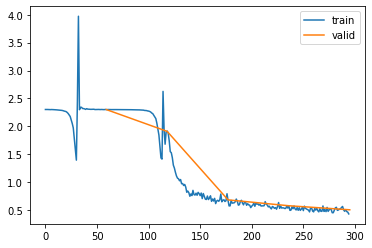

In [ ]:
set_seed(1)

subs = [ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

l = MomentumLearner(cnn_layers(), dls, F.cross_entropy, torch.optim.SGD, 0.1, subs)
l.fit(5)

Although the accuracy is better then what we had with the MLP model, this doesn't look good. The loss is going down and then spikes up to a large value. This happens twice before finally the loss is going down in a stable manner. To understand what's going on, we have to understand what's happening to the activations throughout the network while we are training. 

## Iterative matrix multiplications

But before we do, it's important to realize that in the forward pass of neural networks we iteratively multiply the inputs to the model many times with (different) weight matrices. Let's see how that works by using some artificial data, we generate 1000 random samples of data each with 10 features taken from a unit gaussian (mean=0 and standard deviation=1)

In [ ]:
x = torch.randn(10000, 10) 

Now let's iteratively multiply these inputs with a unit gausian weight matrix mapping from 10 input features to 10 output features and record the mean and standard deviation (std) after each iteration. Theoretically the mean of the outputs should remain 0, since $\mathbb{E}[XY] = \mathbb{E}[X]\mathbb{E}[Y] = 0 * 0 = 0$ if $X$ and $Y$ are independant. But what happens to the std?

In [ ]:
for i in range(10):
    print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')
    w = torch.randn(10, 10)
    x = x@w

"x" multiplied 00 times: mean=    -0.003,   std=          1.000
"x" multiplied 01 times: mean=     0.013,   std=          3.317
"x" multiplied 02 times: mean=    -0.013,   std=          9.330
"x" multiplied 03 times: mean=    -0.009,   std=         32.389
"x" multiplied 04 times: mean=     0.484,   std=        103.563
"x" multiplied 05 times: mean=     2.104,   std=        299.863
"x" multiplied 06 times: mean=     4.431,   std=        948.056
"x" multiplied 07 times: mean=    -4.135,   std=       3229.121
"x" multiplied 08 times: mean=   -74.124,   std=      11527.234
"x" multiplied 09 times: mean=   -38.169,   std=      35325.461


We observe some pretty unstable activations:

- the standard deviation grows exponentially
- initially the mean remains around 0, but eventually it starts to deviate. Probably because the standard deviation is getting larger and larger

This is a big problem for the training of neural networks as input data is passing through the network. When activations are ever increasing so are the gradients which causes the updates to the weights to become too large. 

Let's try the same with a weight matrix that has a smaller standard deviation:

In [ ]:
x = torch.randn(10000, 10) 

for i in range(10):    
    print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')
    w = torch.randn(10, 10) * 0.1 # reduce the standard deviation to 0.1
    x = x@w

"x" multiplied 00 times: mean=     0.004,   std=          1.001
"x" multiplied 01 times: mean=    -0.000,   std=          0.279
"x" multiplied 02 times: mean=    -0.000,   std=          0.072
"x" multiplied 03 times: mean=    -0.000,   std=          0.027
"x" multiplied 04 times: mean=    -0.000,   std=          0.011
"x" multiplied 05 times: mean=     0.000,   std=          0.003
"x" multiplied 06 times: mean=    -0.000,   std=          0.001
"x" multiplied 07 times: mean=     0.000,   std=          0.000
"x" multiplied 08 times: mean=    -0.000,   std=          0.000
"x" multiplied 09 times: mean=     0.000,   std=          0.000


This is not any better, all activations are about the same, and they are all zero! If this happens in a neural network, the network is not learning at all, since the activations and gradients will all be zero.

## Activations

From the above it follows that it's important to keep track of the activations as data flows through the network. Let's try to build this into our framework.

To track the activations we can make use of PyTorch hooks: a function that you can attach to any `nn.Module` and which will be called after the module is being called either during the forward (`register_forward_hook()`) or backward pass (`register_backward_hook()`). Since it's important that we remove the hook after we have used it, let's create a small Hook class, that wraps this logic. We will also store the tracked metrics as attributes on this class.

In [ ]:
class Hook():
    def __init__(self, nr, layer, func):
        wrapped_func = partial(func, self) # pass the Hook object into the function
        self.hook = layer.register_forward_hook(wrapped_func)
        self.layer_name = f'{nr}_{layer.__class__.__name__}'
        
    def remove(self):
        self.hook.remove()

And let's create a Subscriber, that creates and removes the hooks and keeps track of the statistics:

- We will keep track of mean and std as the main metrics we have also been looking at above
- keep track of the histogram counts for additional visibility into the activations
- keep track of the number of activations that are "dead", but more about that later

In [ ]:
class ActivationStatsS(Subscriber):
    
    def __init__(self, modules):
        self.modules = modules
    
    def before_fit(self, learn):
        self.hooks = [Hook(i, module, partial(self.record_stats, learn)) for i, module in enumerate(self.modules)]
        
    def record_stats(self, learn, hook, layer, inp, outp):
        if learn.model.training:
            if not hasattr(hook, 'stats'): hook.stats = ([], [], [], [])
            acts = outp.detach().cpu()
            hook.stats[0].append(acts.mean())              # get the means over all activations
            hook.stats[1].append(acts.std())               # get the stds over all activations
            hook.stats[2].append(acts.histc(20,-10,10))    # get the histogram counts with 20 bins (-10,10)
            
            # computation of the not_firing_rate_per_activation
            N = acts.shape[0]                 
            flat = acts.view(N, -1)                        # flatten the activations: matrix of [samples, activations]
            nf_rate_p_act = (flat == 0.0).sum(dim=0) / N   # compute not firing rate per activations (so across the samples)
            hook.stats[3].append(nf_rate_p_act)   

    def after_fit(self, learn):
        for h in self.hooks: h.remove()

In [ ]:
#|code-fold: true

# This code is folded by default to not clutter the blog
@fc.patch()
def plot(self:ActivationStatsS, figsize=(15,4), average_firing_rate=False):
    plots = 3 if average_firing_rate else 2
    fig,axs = plt.subplots(1,plots, figsize=figsize)
    legend = []
    for h in self.hooks:
        axs[0].plot(h.stats[0])
        axs[0].set_title('mean')
        axs[1].plot(h.stats[1])
        axs[1].set_title('std')
        if average_firing_rate:
            axs[2].plot(1-torch.stack(h.stats[3]).T.mean(dim=0))
            axs[2].set_title('average firing rate')
            axs[2].set_ylim(0,1)
        legend.append(h.layer_name)
    plt.legend(legend);

@fc.patch()
def plot_hist(self:ActivationStatsS, figsize=None, log=True):
    if figsize is None: figsize = (15, len(self.hooks))
    fig,axs = plt.subplots(math.ceil(len(self.hooks)/2), 2, figsize=figsize)
    axs = axs.flat
    for i, hook in enumerate(self.hooks):
        d = torch.stack(hook.stats[2]).T
        if log: d = d.log()
        axs[i].imshow(d, cmap='Blues', origin='lower', aspect='auto')
        axs[i].set_title(hook.layer_name)
        axs[i].set_yticks(np.arange(0, 20, 2), np.arange(-10, 10, 2))

@fc.patch()
def plot_dead(self:ActivationStatsS, binary=False, figsize=None):
    if figsize is None: figsize = (15, len(self.hooks))
    fig,axs = plt.subplots(math.ceil(len(self.hooks)/2), 2, figsize=figsize)
    axs = axs.flat
    for i, hook in enumerate(self.hooks):
        d = torch.stack(hook.stats[3]).T
        if binary: d = d == 1.0
        axs[i].imshow(d, cmap='Greys', origin='lower', aspect='auto')
        axs[i].set_title(hook.layer_name)

In [ ]:
set_seed(1)

model = cnn_layers()

# show activation stats on all ReLU layers
modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules)

subs = [act_stats,
        DeviceS(device)]

l = MomentumLearner(model, dls, F.cross_entropy, torch.optim.SGD, 0.1, subs)
l.fit(5)

Let's have a look at the mean and std's of the layers as we progressively train the model. On the horizontal axis the number of batches are displayed and the coloured lines depict the mean and std respectively of the activations in the layers we are tracking (all the ReLU layers in our model):

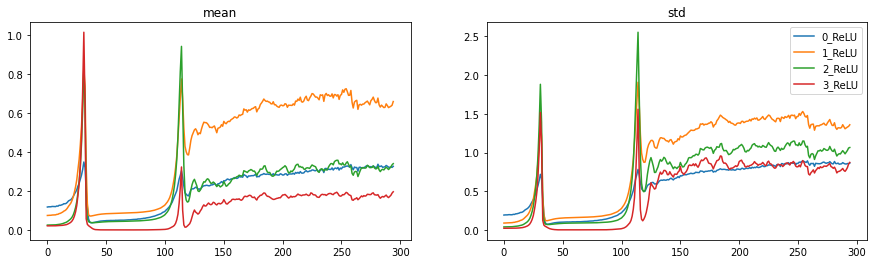

In [ ]:
act_stats.plot()

These plots show a similar problem to what we saw in the loss plots: two large spikes during training. In the beginning the means are nice and small (around 0), but the std's are way too small (also around 0). There is thus very little variation in our activations. The std then increases exponentially (*exactly as we have seen in the iterative matrix multiplication example above!*) and crashes back to zero. This patterns repeats once again, and then finally the std's stabilize around a value somewhat in the range of 1.

Let's also have a look at the histogram plots, these plots show a single histogram **vertically**. On the horizontal axis we have again number of batches. Vertically we display a histogram as a heatmap (to help with the colorscale, we actually display the log of the histogram counts): e.g. high counts in a bin correspond to a dark blue color. The histogram records values on the vertical axis from -10 to 10, so a dark blue horizontal line around zero indicates that through many batches all (most) activations are close to zero. Since we are tracking the stats of ReLU layers there are no counts below zero.

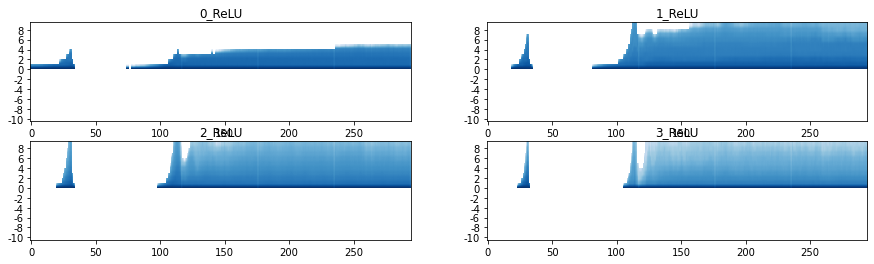

In [ ]:
act_stats.plot_hist()

Finally, we can also have a look at the percentage of "dead activations" of our ReLU neurons. Remember that a ReLU neuron passes the data directly through if the data is larger than 0, and outputs 0 whenever the data is below 0. Whenever the data is clipped at zero, it's gradient will also be zero (since the derivative of a horizontal line is zero). For backpropagation this means that all the upstream gradient components that flow through this neuron will all be zero, which translates to no updates.

In principle it's not immediately a problem when for some samples the ReLU output is zero, however when this happens for all samples in a batch, or even worse for all batches in an epoch (all our data), we basically have a dead neuron. All gradients that flow upstream from this neuron will always be zero. This is what Andrej Karpathy calls "permanent brain damage of a neural net".

We are tracking how often this happens per batch, i.e. **we compute the "none-firing-rate" per ReLU activation**: if none of the samples in a batch have a positive ReLU output we record a value of 1.0, if for 50% of the samples the ReLU output is positive we record a value of 0.5.

With the following plots, we display those neurons that don't fire a single time in a minibatch (black) vs those neurons that fire at least for one sample in the batch (white). Horizontally the batches, vertically the activations per layer (CxHxW)

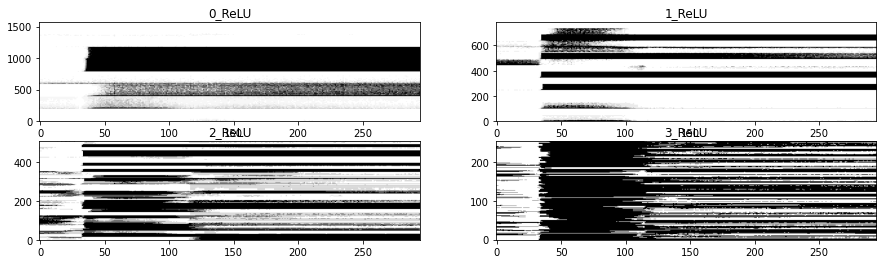

In [ ]:
act_stats.plot_dead(binary=True)

As expected, we are seeing a very large number of black clusters. Especially starting from the two spikes we identified above, we see many neurons being totally thrown of, and never recover anymore from it. This is a sign of severe training problems.

## Initialization

We have seen the importance of keeping the activations stable throughout training, and we have seen how we can monitor these activations. 

A first effort at stabilizing the activations, is by taking care of the initialization of the network, which is the process of setting the weights *before* they are trained. Above, it was shown that if the std of the weights is too large, our activations explode over time and if the std is too small the activations vanish. Can we set the std to a value that is just right, and makes sure the std of the activations stays roughly 1?

With Xavier initialization, the weight matrices are initialized in such a way that activations taken from a unit gaussian don't explode or vanish as we have seen above. It turns out, that we have to scale the standard deviation by $1/\sqrt{n_{in}}$

In [ ]:
x = torch.randn(10000, 10) 

# reduce the standard deviation by a factor of 1/sqrt(10)
w3 = torch.randn(10, 10) * (1/math.sqrt(10))

for i in range(10):
    x = x@w3
print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')

"x" multiplied 09 times: mean=    -0.002,   std=          0.882


However, this doesn't solve everything. Since we also have activation functions sitting in between our matrix mulitplies. Activations typically squash the activations:

In [ ]:
x = torch.randn(10000, 10) 

# reduce the standard deviation by a factor of 1/sqrt(10)
w4 = torch.randn(10, 10) * (1/math.sqrt(10))

for i in range(10):
    x = (x@w3).relu()
print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')

"x" multiplied 09 times: mean=     0.004,   std=          0.009


And as expected, everyhing has imploded to zero. It turns out that we can correct for this squashing by adding a gain. This is called Kaiming initialization. For example the gain for ReLU is $\sqrt{2}$:

In [ ]:
x = torch.randn(10000, 10)

# add a gain of sqrt(2)
w4 = torch.randn(10, 10) * math.sqrt(2/10)

for i in range(10):
    x = torch.nn.functional.relu((x@w4))
print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')

"x" multiplied 09 times: mean=     1.222,   std=          1.627


So let's apply Kaiming initialization to our model, and see how it performs:

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d): torch.nn.init.kaiming_normal_(m.weight)

epoch,mode,loss,accuracy
0,train,1.410,0.561
0,eval,0.626,0.768
1,train,0.508,0.814
1,eval,0.465,0.832
2,train,0.417,0.849
2,eval,0.431,0.844
3,train,0.377,0.863
3,eval,0.392,0.861
4,train,0.357,0.870
4,eval,0.385,0.860


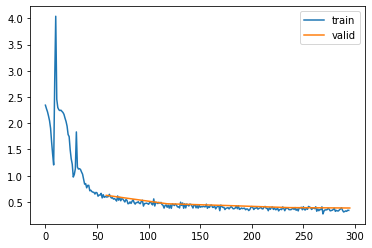

In [ ]:
set_seed(1)

model = cnn_layers().apply(init_weights)

modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules)

subs = [act_stats,
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

l = MomentumLearner(model, dls, F.cross_entropy, torch.optim.SGD, 0.1, subs)
l.fit(5)

Propper initialization increases the performance from 82% to around 87%, also the loss graph looks a bit better. Let's have a look at our activation plots:

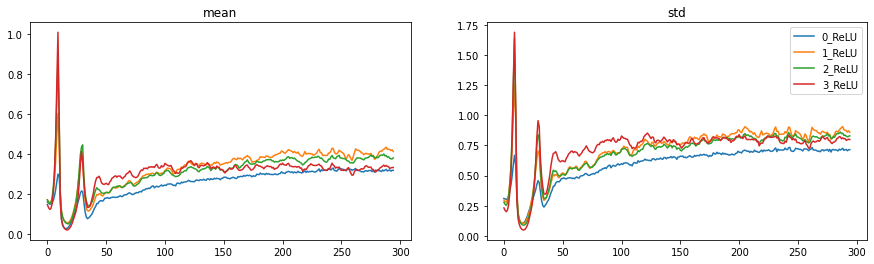

In [ ]:
act_stats.plot()

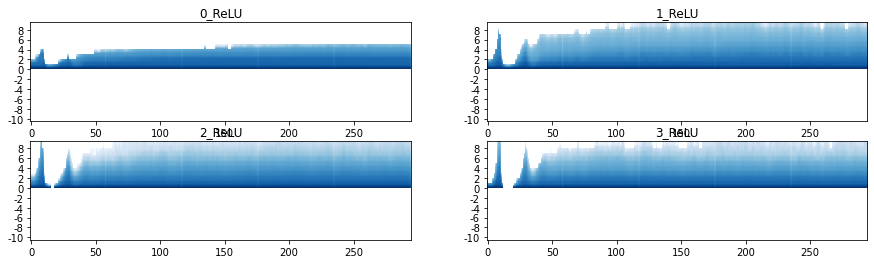

In [ ]:
act_stats.plot_hist()

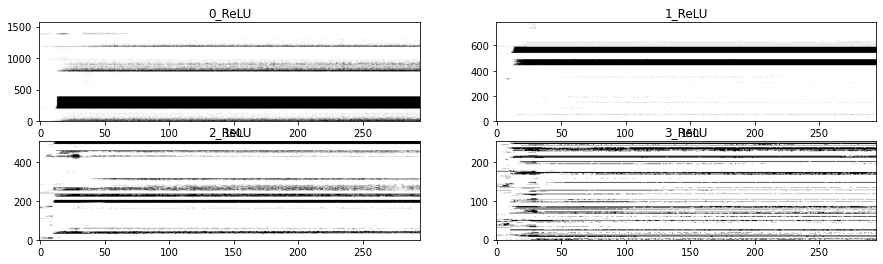

In [ ]:
act_stats.plot_dead(binary=True)

A lot better indeed, but we still see some "brain damage" occuring after the spikes.

## Normalisation

Besides initializing the weight matrices properly, we can also normalize the data itself. Since the batch size is quite large (1024) let's do so by taking the statistics of the first batch:

In [ ]:
xb_mean = xb.mean()
xb_std = xb.std()

Create a small Subscriber that normalizes our inputs before a batch:

In [ ]:
class NormalizationS(Subscriber):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def before_batch(self, learn):
        learn.batch = [(learn.batch[0] - self.mean) / self.std, learn.batch[1]]

epoch,mode,loss,accuracy
0,train,0.882,0.699
0,eval,0.486,0.821
1,train,0.426,0.845
1,eval,0.412,0.853
2,train,0.378,0.861
2,eval,0.392,0.855
3,train,0.341,0.875
3,eval,0.358,0.868
4,train,0.322,0.883
4,eval,0.374,0.864


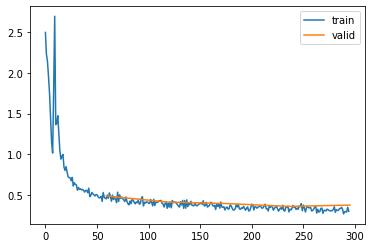

In [ ]:
set_seed(1)

model = cnn_layers().apply(init_weights)

modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules)

norm = NormalizationS(xb_mean, xb_std)

subs = [norm, 
        act_stats,
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

l = MomentumLearner(model, dls, F.cross_entropy, torch.optim.SGD, 0.1, subs)
l.fit(5)

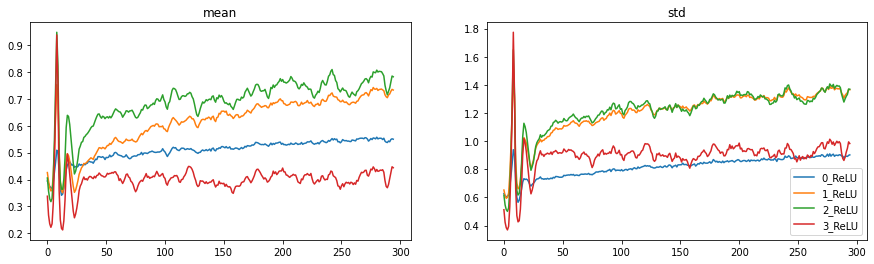

In [ ]:
# act_stats.plot(dead=True)
act_stats.plot()

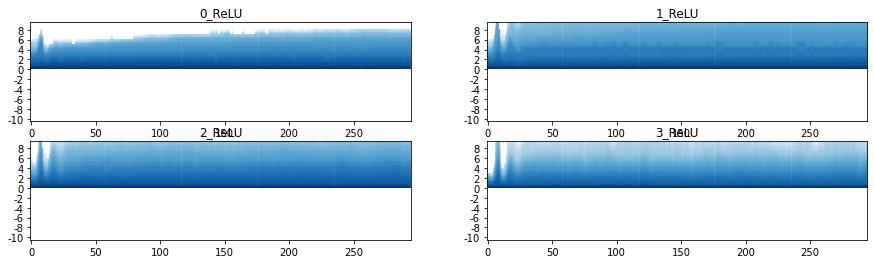

In [ ]:
act_stats.plot_hist()

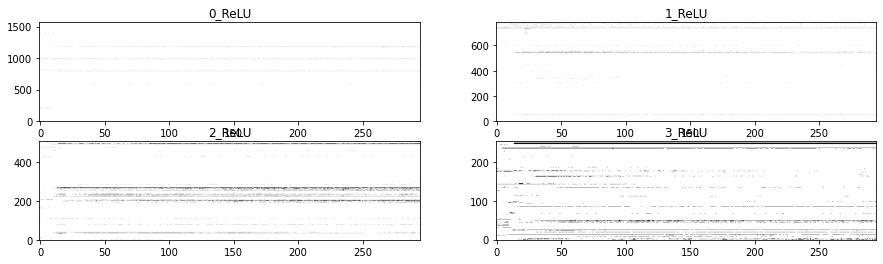

In [ ]:
act_stats.plot_dead(binary=True)

These are all good improvements. The histogram plots start to look a lot better and the amount of dead neurons is greatly reduced. We still have problems though in the beginning of training.

## Batch Normalization

So far we have tried to tackle the problems around activations from two sides. These are effective measures, but don't cover the full problem: the weights are updated during training after which they are no longer normalized and after we normalize our data we just "have to send it through the network" and see what happens with the activations. 

The idea behind batch normalization is remarkably simple: if we know that we need unit gaussian activations throughout the network, let's just make them unit gaussian🤓. This might sound a bit weird, but in fact the normalization operation is perfectly differentiable, and thus the gradients can be backpropagated. Batch normalization takes the form of a layer and normalizes each batch during training. 

Let's start with the basic functionality, a layer that normalizes a batch of data. Note that Batchnorm normalizes the batch across the batch, height and width, but not across the channels. So when passing RGB images through your network, the mean and std would have 3 values each (for a Batchnorm layer that would act directly upon the inputs)

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, xb):
        mean = xb.mean(dim=(0,2,3), keepdim=True)
        std = xb.std(dim=(0,2,3), keepdim=True)
        return (xb - mean) / std

In [ ]:
xb.mean(dim=(0,2,3)), xb.std(dim=(0,2,3))

(tensor([0.2884]), tensor([0.3561]))

In [ ]:
out = BatchNorm().forward(xb)
out.mean(dim=(0,2,3)), out.std(dim=(0,2,3))

(tensor([-2.7065e-08]), tensor([1.]))

An interesting and somewhat remarkable consequence of this layer, is that the activations of a single sample in the batch are getting coupled to the activations of the other samples in the batch, since the mean and std of the batch are computed across all the samples. This leads to all sort of strange behavior and after batch normalization other normalization layers have been developed which don't have this property: such as layer, group or instance normalization. But as it turns out, this coupling also has a regularizing effect. Since the coupling of samples acts somewhat similarly to data augmentation.

Additionally, batchnorm defines two parameters `mult` and `add` by which the outputs are multiplied by and added to. These parameters are initialized at 1 and 0, meaning that at the very start of training these layers are in fact normalizing the data. However, they are *learnable* parameters, so during training these values can be changed if the model sees fit. This means that a Batchnorm layer can in fact do something totally different then normalizing the data!

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.mult = torch.nn.Parameter(torch.ones(nf, 1, 1)) # also computed per channel
        self.add = torch.nn.Parameter(torch.zeros(nf, 1, 1)) # also computed per channel
        
    def forward(self, xb):
        mean = xb.mean(dim=(0,2,3), keepdim=True)
        std = xb.std(dim=(0,2,3), keepdim=True)
        return self.mult * (xb - mean) / std + self.add

One problem with this, is that during inference we would like to be able to pass in just a single sample. However, because of the batchnorm layer which is expecting a full batch of data, it's no longer clear how to get sensible predictions out of the model. One way to solve this is to keep running statistics of the mean and std during training and just use these when performing inference. Let's add that as well:

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1):
        super().__init__()
        self.mom = mom
        self.mult = torch.nn.Parameter(torch.ones(nf, 1, 1))
        self.add = torch.nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('std',  torch.ones(1,nf,1,1))    # make sure they are stored during export
        self.register_buffer('mean', torch.zeros(1,nf,1,1))   # make sure they are stored during export
        
    def update_stats(self, xb):
        mean = xb.mean(dim=(0,2,3), keepdim=True)
        std = xb.std(dim=(0,2,3), keepdim=True)
        self.mean.lerp_(mean, self.mom)                        # take a weighted average (in place) between self.mean and mean
        self.std.lerp_(std, self.mom)                          # same with self.std and std
        
    def forward(self, xb):
        if self.training:
            with torch.no_grad(): self.update_stats(xb)
        return self.mult * ((xb - self.mean) / self.std) + self.add

To add this to our model we have to redefine some functions:

In [ ]:
def conv_block(in_c, out_c, kernel_size=3, act=True, norm=True):
    padding = kernel_size // 2
    stride = 2
    layers = [torch.nn.Conv2d(in_c, out_c, kernel_size, stride, padding, bias=not norm)]
    if norm: layers.append(torch.nn.BatchNorm2d(out_c))
    if act: layers.append(torch.nn.ReLU())
    return nn.Sequential(*layers) if len(layers)>1 else layers[0]

In [ ]:
def cnn_layers(act=True):
    return nn.Sequential(                  
        conv_block(1 , 8, kernel_size=5),
        conv_block(8 ,16),
        conv_block(16,32),
        conv_block(32,64),
        conv_block(64,10, norm=False, act=False),
        nn.Flatten())

epoch,mode,loss,accuracy
0,train,0.573,0.794
0,eval,0.410,0.847
1,train,0.340,0.876
1,eval,0.348,0.872
2,train,0.306,0.887
2,eval,0.344,0.874
3,train,0.276,0.899
3,eval,0.341,0.878
4,train,0.262,0.902
4,eval,0.304,0.891


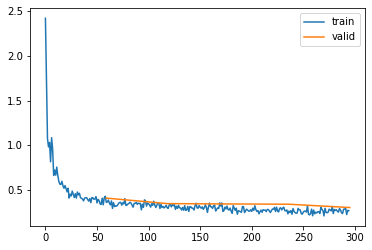

In [ ]:
set_seed(1)

model = cnn_layers().apply(init_weights)

modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules)

norm = NormalizationS(xb_mean, xb_std)

subs = [norm, 
        act_stats,
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

l = MomentumLearner(model, dls, F.cross_entropy, torch.optim.SGD, 0.4, subs)
l.fit(5)

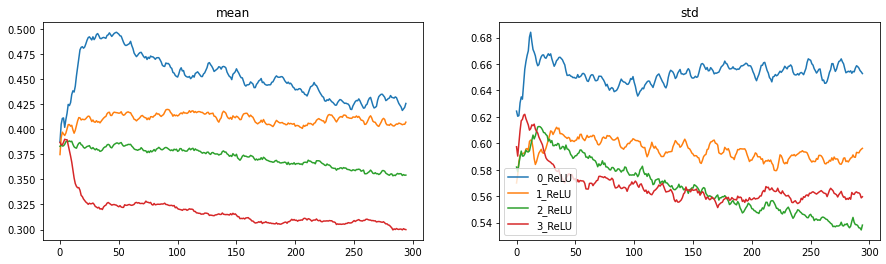

In [ ]:
# act_stats.plot(dead=True)
act_stats.plot()

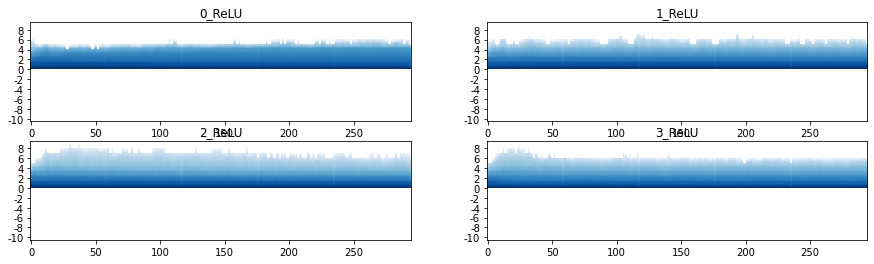

In [ ]:
act_stats.plot_hist()

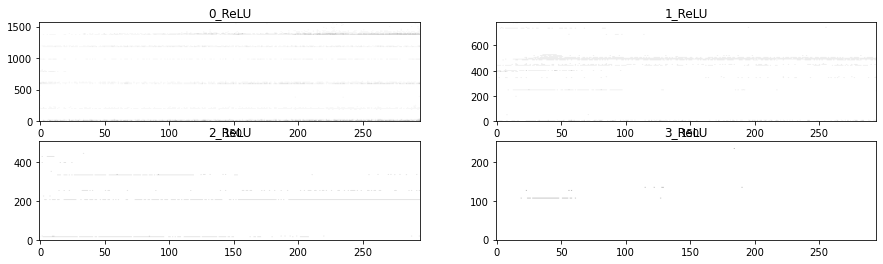

In [ ]:
act_stats.plot_dead(binary=True)

And this is all looking very good, no more spikes in the loss, histograms are looking good and no or very little permanently dead neurons.

Let's have a final look at the "dead plot". Without the `binary=True` it displays the average dead rate across the samples in in the minibatch.

Additionally we can plot the average firing rate across all neurons:

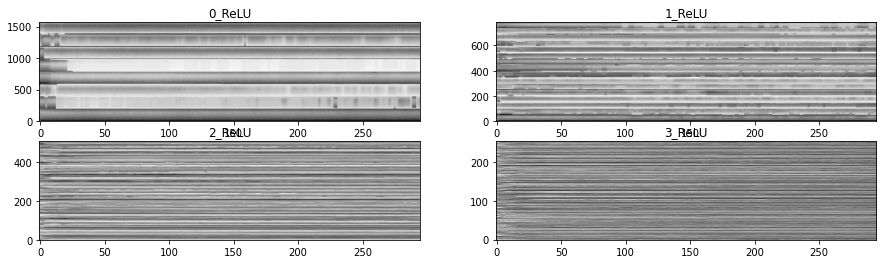

In [ ]:
act_stats.plot_dead()

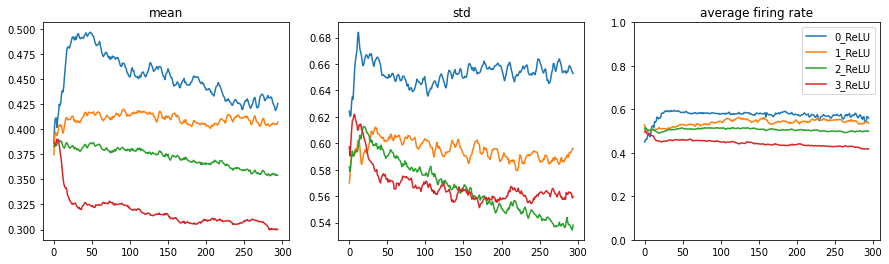

In [ ]:
act_stats.plot(average_firing_rate=True)

From which we see that on average all ReLU neurons fire for around 50% of the samples in a minibatch. Some fire a bit less (darker) some fire a bit more (brighter), but we have very little neurons that never fire (black).

## Final remarks

We have again come a long way, and have seen how we can make sure to train a neural network properly. We have learned to look at activations from many angles, and improved our model up to around 89% accuracy by careful initialization and normalization.